<center><h1><b>Battle of neighbourhoods</b></h1>
<h2>Toronto edition</h2>
<h4>By <a href="franciscot.dev">Francisco Tarantuviez</a></h4></center>
 <hr />

### Problem to solve
    I am currently living in the West Side of Toronto, Canada in a neighbourhood called Dufferin, Dovercourt Village. I love where I live because all the amenities that the neighbourhood has (such as restaurants, gyms, coffee shops, etc). The problem start when I recive a spectacular job offer that I cannot reject, but the place of the job is far of Dufferin. So, I want to take a good decision, a data driven decision. Then, via Machine Learning techniques and Exploratory Data Analysis (EDA) I'll understand and compare the neighbourhoods in all Toronto having two principal parameters:

       1. Distance between the neighbourhood and the job place
   
       2. Similarity between my actual neighbourhood and the future one

### Dataset

The dataset already passed the ETL process (Extract, Transform and Load). Currently is loaded in a database in IBM storage, but you can find it in this [url](https://github.com/ftarantuviez/data_science_capstone/blob/master/project_toronto/ETL_notebooks/datasets/toronto-venues.csv)

Let's review the dataset to understand it a little more:

- Number of rows: 2378
- Number of columns: 11

##### Columns:
- ven_id (string): the venue id in Foursquare API
- ven_name (string): name of the venue
- ven_lat (float): latitude of the venue
- ven_lng (float): longitude of the venue
- ven_category_name (string): venue category name
- ven_category_id (string): identifier value of the category in Foursquare API
- ven_address (string): street and number of the venue
- neighbourhood (string): name of the neighbourhood
- neighbourhood_lat (float): neighbourhood latitude
- neighbourhood_lng (float): neighbourhood longitude
- borough (string): borough of the neighbourhood name

In [114]:
# packages that will be used

# basic data manipulation
import pandas as pd
import numpy as np

# visualation packages
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# database
import ibm_db
import ibm_db_dbi

# geospacial operations
import geopy.distance

# data transformation and modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics

In [116]:
# useful variables
current_neigh = "Dufferin, Dovercourt Village"
job_neigh = "Rouge Hill, Port Union, Highland Creek"
toronto_location = [43.6532, -79.3832]

In [4]:
# magic sql
%load_ext sql

In [5]:
# open connection with the database
%sql ibm_db_sa://jts01551:67sk^vschz4h148z@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

DB2/LINUXX8664


'Connected: jts01551@BLUDB'

In [6]:
%sql SELECT TABSCHEMA, TABNAME, CREATE_TIME FROM SYSCAT.TABLES where TABSCHEMA='JTS01551' ORDER BY create_time DESC

 * ibm_db_sa://jts01551:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
JTS01551,TORONTO-VENUES-NEIGHBOURHOODS,2021-01-31 16:30:41.041424
JTS01551,CHICAGO_CRIME,2021-01-23 20:54:42.959854
JTS01551,CHICAGO_SCHOOLS,2021-01-23 20:50:06.734306
JTS01551,CHICAGO_SOCIOECONOMIC,2021-01-23 20:47:04.596609
JTS01551,SCHOOLS,2021-01-23 19:12:19.655471
JTS01551,SCHOOLS_CHICAGO,2021-01-23 19:05:07.347107
JTS01551,MCDONALDS,2021-01-22 16:45:44.098727
JTS01551,INSTRUCTOR,2021-01-22 04:23:41.116508
JTS01551,PETRESCUE,2021-01-21 15:49:04.715313
JTS01551,LOCATIONS,2021-01-21 13:22:55.610166


In [7]:
result = %sql SELECT * FROM "TORONTO-VENUES-NEIGHBOURHOODS"

 * ibm_db_sa://jts01551:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


In [8]:
df = result.DataFrame()

In [9]:
df.head()

,ven_id,ven_name,ven_lat,ven_lng,ven_category_name,ven_category_id,ven_address,neighbourhood,neighbourhood_lat,neigbourhood_long,borough
0,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976046055574,-79.33214044722958,Park,4bf58dd8d48988d163941735,Toronto,Parkwoods,43.75,-79.33,North York
1,4e13a489b0fb5dfdd0756c90,PetSmart,43.748639084843475,-79.33348827385937,Pet Store,4bf58dd8d48988d100951735,Ontario,Parkwoods,43.75,-79.33,North York
2,4cb11e2075ebb60cd1c4caad,Variety Store,43.75197441585782,-79.33311418516017,Food & Drink Shop,4bf58dd8d48988d1f9941735,29 Valley Woods Road,Parkwoods,43.75,-79.33,North York
3,4aec8a50f964a5207ac821e3,Armenian Kitchen,43.73107096414275,-79.30539020048727,Middle Eastern Restaurant,4bf58dd8d48988d115941735,1646 Victoria Park Ave,Victoria Village,43.73,-79.31,North York
4,4fff5c20e4b02bc662e83585,Blue Water Curry,43.731046,-79.30533000000000,Caribbean Restaurant,4bf58dd8d48988d144941735,1646 Victoria Park,Victoria Village,43.73,-79.31,North York


### Lets check the features

We can see some columns that are not useful for this notebook, such as the venue id in the foursquare API. In other moment, with that value we can extract more data, but now is not the idea.
So, let's remove the following columns:
- ven_id
- ven_category_id

In [10]:
df.drop(columns=["ven_id", "ven_category_id"], inplace=True)

### Add new features

We already have the location of each neighbourhood, but let get it the distance in kilometers in relation with the job neighbourhood.
We can find the distance in kilometers with help of the module *geopy* with the function distance

In [11]:
job_neigh_data = df[df["neighbourhood"] == job_neigh][["neighbourhood_lat", "neigbourhood_long"]].values[0]
job_neigh_loc = (job_neigh_data[0],job_neigh_data[1])
get_distance_job_neigh = lambda x: np.round(
        geopy.distance.distance(
            (x["neighbourhood_lat"], x["neigbourhood_long"]),job_neigh_loc).km ,2)

df["dist_job_neigh_km"] = df.apply(get_distance_job_neigh, axis=1)

df.head()

,ven_name,ven_lat,ven_lng,ven_category_name,ven_address,neighbourhood,neighbourhood_lat,neigbourhood_long,borough,dist_job_neigh_km
0,Brookbanks Park,43.751976046055574,-79.33214044722958,Park,Toronto,Parkwoods,43.75,-79.33,North York,14.39
1,PetSmart,43.748639084843475,-79.33348827385937,Pet Store,Ontario,Parkwoods,43.75,-79.33,North York,14.39
2,Variety Store,43.75197441585782,-79.33311418516017,Food & Drink Shop,29 Valley Woods Road,Parkwoods,43.75,-79.33,North York,14.39
3,Armenian Kitchen,43.73107096414275,-79.30539020048727,Middle Eastern Restaurant,1646 Victoria Park Ave,Victoria Village,43.73,-79.31,North York,13.80
4,Blue Water Curry,43.731046,-79.30533000000000,Caribbean Restaurant,1646 Victoria Park,Victoria Village,43.73,-79.31,North York,13.80


[//]: # "This space was intentionally left in blank :p"

Here below we can notice the distance between our current neighbourhood to the job neighbourhood

In [12]:
print("""The distance of {} (current neighbourhood) in relation with {} (job neighbourhood) is {}km
      """.format(current_neigh, job_neigh, df[df["neighbourhood"] == current_neigh]["dist_job_neigh_km"].values[0]))

The distance of Dufferin, Dovercourt Village (current neighbourhood) in relation with Rouge Hill, Port Union, Highland Creek (job neighbourhood) is 26.2km
      


In [13]:
df.groupby("neighbourhood").count()

,ven_name,ven_lat,ven_lng,ven_category_name,ven_address,neighbourhood_lat,neigbourhood_long,borough,dist_job_neigh_km
neighbourhood,,,,,,,,,
Agincourt,10,10,10,10,10,10,10,10,10
"Alderwood, Long Branch",7,7,7,7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4,4,4,4
Bayview Village,4,4,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26,26,26,26
...,...,...,...,...,...,...,...,...,...
"Willowdale, Willowdale West",3,3,3,3,3,3,3,3,3
Woburn,3,3,3,3,3,3,3,3,3
Woodbine Heights,8,8,8,8,8,8,8,8,8


### One Hot Encoding

Let's extract useful information about the types of categories in each neighbourhood. To achive that, let's use One Hot Encoding technique

In [14]:
venues_onehot = pd.get_dummies(df[["ven_category_name"]], prefix="", prefix_sep="")
venues_onehot["neighourhood"] = df["neighbourhood"]

fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()

,neighourhood,Accessories Store,Airport,American Restaurant,Animal Shelter,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
neighbourhoods_groupped = venues_onehot.groupby("neighourhood").mean().reset_index()
neighbourhoods_groupped.head()

,neighourhood,Accessories Store,Airport,American Restaurant,Animal Shelter,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,Bayview Village,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.038462,0.038462,0.0


##### Here we define a function to extract the five most normal venues by neighbourhood

In [16]:
def get_five_common_venues(row,number_of_venues=5):
    return row.iloc[1:].sort_values(ascending=False)[:number_of_venues]

##### Let's first watch the frequency of venues in our neighbourhood

Text(0, 0.5, 'Frequency')

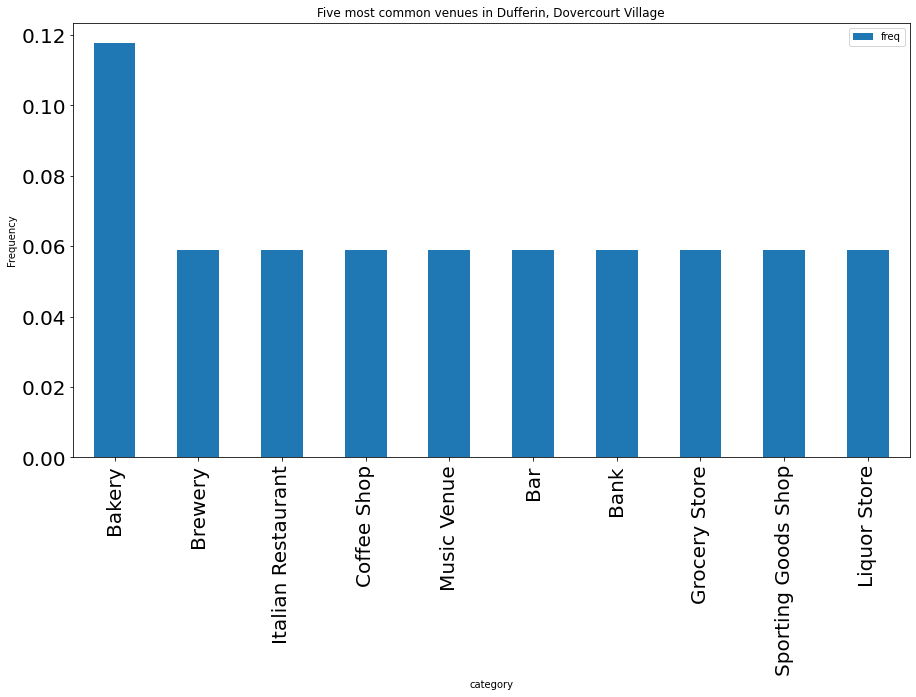

In [17]:
current_neigh_data = neighbourhoods_groupped[neighbourhoods_groupped["neighourhood"] == current_neigh].iloc[0,:]

five_most_common_by_actual_neigh = get_five_common_venues(current_neigh_data, 10)

pd.DataFrame(five_most_common_by_actual_neigh.reset_index()).rename(columns={"index": "category", 23: "freq"}).plot(kind="bar", x="category", y="freq", figsize=(15,8), fontsize=20)
plt.title("Five most common venues in {}".format(current_neigh))
plt.ylabel("Frequency")

#### Now let's search the five most common in all the neighbourhoods

In [18]:
for neigh in neighbourhoods_groupped["neighourhood"]:
    print("----"+neigh+"----")
    tmp=pd.DataFrame(get_five_common_venues(neighbourhoods_groupped[neighbourhoods_groupped["neighourhood"] == neigh].iloc[0,:])).reset_index()
    tmp.columns=["category", "freq"]
    tmp.freq = tmp.freq.astype(float)
    tmp.freq = np.round(tmp.freq,2)
    print(tmp)
    print("\n")

----Agincourt----
                    category  freq
0  Latin American Restaurant   0.1
1                     Lounge   0.1
2                  Pool Hall   0.1
3        American Restaurant   0.1
4         Seafood Restaurant   0.1


----Alderwood, Long Branch----
       category  freq
0  Dance Studio  0.14
1   Pizza Place  0.14
2           Gym  0.14
3   Coffee Shop  0.14
4   Gas Station  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                   category  freq
0  Mediterranean Restaurant  0.25
1       American Restaurant  0.25
2                  Bus Line  0.25
3               Pizza Place  0.25
4               Yoga Studio  0.00


----Bayview Village----
                     category  freq
0                        Park  0.25
1  Construction & Landscaping  0.25
2                 Flower Shop  0.25
3                       Trail  0.25
4                 Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
             category  freq
0  Italian Restaurant  0.08
1  

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Now let's put all of the above into a DataFrame

In [20]:
num_top_venues = 10
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

top_venues=pd.DataFrame(columns=columns)
top_venues["Neighborhood"] = neighbourhoods_groupped["neighourhood"]

for i in np.arange(neighbourhoods_groupped.shape[0]):
     top_venues.iloc[i,1:] = return_most_common_venues(neighbourhoods_groupped.iloc[i,:], num_top_venues)
top_venues.head()

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Pool Hall,American Restaurant,Seafood Restaurant,Bakery,Breakfast Spot,Sandwich Place,Mediterranean Restaurant,Caribbean Restaurant
1,"Alderwood, Long Branch",Dance Studio,Pizza Place,Gym,Coffee Shop,Gas Station,Athletics & Sports,Pub,Food & Drink Shop,Flower Shop,Food Court
2,"Bathurst Manor, Wilson Heights, Downsview North",Mediterranean Restaurant,American Restaurant,Bus Line,Pizza Place,Yoga Studio,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
3,Bayview Village,Park,Construction & Landscaping,Flower Shop,Trail,Yoga Studio,Fish & Chips Shop,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Park,Bank,Liquor Store,Locksmith,Sushi Restaurant,Grocery Store,Juice Bar


#### Now let's cluster our data

In [21]:
# drop neighbourhood from dataset
neighbourhoods_groupped_clustering = neighbourhoods_groupped.drop("neighourhood", axis=1)
neighbourhoods_groupped_clustering.head()

,Accessories Store,Airport,American Restaurant,Animal Shelter,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.038462,0.038462,0.0


## KMeans

In [22]:
# Defining the scoring
def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(distance_matrix, clusters, metric='precomputed')
    return score

Text(0, 0.5, 'K')

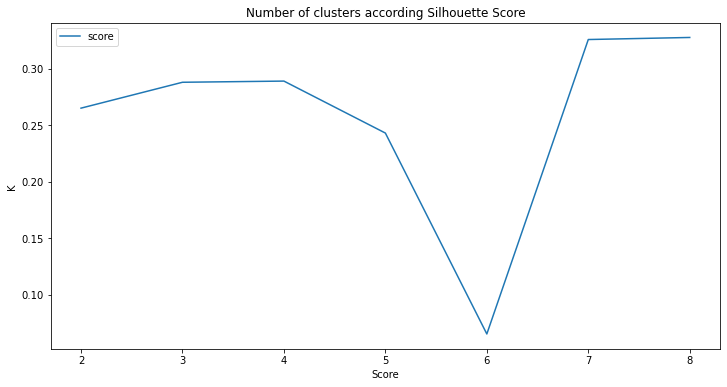

In [46]:
scores = []
for k in np.arange(2,9):
    clusters = KMeans(n_clusters=k).fit(neighbourhoods_groupped_clustering)
    score = metrics.silhouette_score(neighbourhoods_groupped_clustering, clusters.labels_)
    scores.append({"k_number":k, "score": score})

pd.DataFrame(scores).plot(x="k_number", y="score", figsize=(12,6))
plt.title("Number of clusters according Silhouette Score")
plt.xlabel("Score")
plt.ylabel("K")

#### As we can see in the above chart, the best score is given when k = 4
##### Now let's tune hyperparameters with GridSearchCV

In [118]:
k_number = 7
kmeans_parameters = {
    "n_clusters": [k_number],
    "init": ["k-means++", "random"],
    "algorithm": ["auto", "full", "elkan"]
}
gs_kmeans = GridSearchCV(KMeans(), param_grid=kmeans_parameters)
gs_kmeans.fit(neighbourhoods_groupped_clustering)

GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ['auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'], 'n_clusters': [7]})

In [119]:
print("The best parameters to use in KMeans are:: ")
print("Algorithm: " + gs_kmeans.best_params_["algorithm"])
print("Init: " + gs_kmeans.best_params_["init"])
print("Number of clusters: " + str(k_number))

The best parameters to use in KMeans are:: 
Algorithm: full
Init: k-means++
Number of clusters: 7


In [121]:
labels_kmeans = gs_kmeans.best_estimator_.fit(neighbourhoods_groupped_clustering).labels_
top_venues.drop("Cluster", axis=1, inplace=True)
top_venues.insert(0, "Cluster", labels_kmeans)

In [122]:
df_merged = df[["neighbourhood", 
                "neighbourhood_lat", 
                "neigbourhood_long", 
                "borough", 
                "dist_job_neigh_km"]].drop_duplicates(subset=["neighbourhood"]).reset_index(drop=True)
df_merged = df_merged.join(top_venues.set_index('Neighborhood'), on="neighbourhood")

In [123]:
# create map
map_clusters = folium.Map(location=toronto_location, zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_number)
ys = [i + x + (i*x)**2 for i in range(k_number)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['neighbourhood_lat'], df_merged['neigbourhood_long'], df_merged['neighbourhood'], df_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [124]:
df_merged[df_merged["Cluster"] == 3]

,neighbourhood,neighbourhood_lat,neigbourhood_long,borough,dist_job_neigh_km,Cluster,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.75,-79.33,North York,14.39,3,Food & Drink Shop,Pet Store,Park,Yoga Studio,Falafel Restaurant,Fountain,Food Truck,Food Court,Flower Shop,Flea Market
7,Don Mills,43.74,-79.36,North York,17.04,3,Park,Gym,Grocery Store,Deli / Bodega,Intersection,Coffee Shop,Fish & Chips Shop,Fast Food Restaurant,Field,Filipino Restaurant
20,Caledonia-Fairbanks,43.69,-79.45,York,25.87,3,Bakery,Park,Sporting Goods Shop,Gym,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Falafel Restaurant
31,Scarborough Village,43.75,-79.23,Scarborough,7.18,3,Park,Grocery Store,Yoga Studio,Falafel Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
38,Bayview Village,43.78,-79.38,North York,17.74,3,Park,Construction & Landscaping,Flower Shop,Trail,Yoga Studio,Fish & Chips Shop,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market
49,"Cliffside, Cliffcrest, Scarborough Village West",43.72,-79.23,Scarborough,9.61,3,Construction & Landscaping,Park,Summer Camp,Yoga Studio,Fish Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flower Shop
54,"Birch Cliff, Cliffside West",43.70,-79.26,Scarborough,12.84,3,Park,Gym,Gym Pool,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Ethiopian Restaurant
56,Lawrence Park,43.73,-79.39,Central Toronto,19.68,3,Business Service,Park,Electronics Store,Yoga Studio,Farmers Market,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop
59,Weston,43.71,-79.52,York,30.33,3,Park,Outdoors & Recreation,Yoga Studio,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market
61,York Mills West,43.75,-79.40,North York,19.83,3,Convenience Store,Park,Yoga Studio,Falafel Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
